In [1]:
import numpy as np
import pandas as pd
import io
import glob
import os

In [2]:
def df_from_csv(my_csv):
    return pd.read_csv(io.StringIO('\n'.join(my_csv[2:-1])))

In [3]:
def get_nsys_reports(parent_directory, trial_name, folder_destination='artifacts/'):
    report_paths = glob.glob(parent_directory + '/*-rep')
    time_holder, size_holder = [], []
    for path in report_paths:
        time_csv = !nsys stats --report=gpumemtimesum --format csv -q $path
        size_csv = !nsys stats --report=gpumemsizesum --format csv -q $path
        time_holder.append(df_from_csv(time_csv))
        size_holder.append(df_from_csv(size_csv))
    time_df = pd.concat(time_holder, axis=0, ignore_index=True)
    size_df = pd.concat(size_holder, axis=0, ignore_index=True)
    time_df.to_csv(folder_destination + trial_name +'-time.csv', index=False)
    size_df.to_csv(folder_destination + trial_name +'-size.csv', index=False)
    return time_df, size_df

The function above will extract relevant information for gpu memory and time and save them into their own respective csv files. Useful for/with nsys plotting notebook.

Below we'll put together some functions to extract information to ask the question: how much of our total training time is being used up by gpu compute?

In [4]:
trial_names = ['r50', 'r50-256bs', 'r50-phylum', 'r50-pytorch', 'r50-1gpu', 
               'r50-accum-1gpu', 'r50-accum-4gpu', 'r50-tl', 'r101']

In [5]:
folder_path = '/global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3443950'
file_name = os.listdir(folder_path)[0]
file_path = folder_path + f'/{file_name}' 
file_name

'nsys_report.nid001544.129059.nsys-rep'

In [6]:
#this is how we can get the amount of time for training
log_file = folder_path + '.log'
log_total_slist = !grep "Total seconds:*" {log_file}
float(log_total_slist[0].split()[-1])

115.527566

In [7]:
def get_logged_time(folder_path):
    log_file = folder_path + '.log'
    log_total_slist = !grep "Total seconds:*" {log_file}
    return float(log_total_slist[0].split()[-1])

In [8]:
get_logged_time(folder_path)

115.527566

In [9]:
#leads to unwieldy output without grep, couldn't figure out how to only pull int starting lines
full_file = !nsys stats --report=gpukernsum --format csv -q $file_path
#len(full_file)#full_file

nccl = !nsys stats --report=gpukernsum --format csv -q $file_path | grep nccl
#nccl #if want to see nccl activities

#total time is second column - first col is % time
#nccl[0].split(',')[1]

#this should get the total number of seconds for nccl related activities
np.array([x.split(',')[1] for x in nccl], dtype=float).sum() / 1e9

59.748935084

In [70]:
def get_nccl_sum(file_path):
    nccl_activities = !nsys stats --report=gpukernsum --format csv -q {file_path} | grep nccl
    total = np.array([x.split(',')[1] for x in nccl_activities], dtype=float).sum() / 1e9
    return total

#hardcoded in 100 of the activities -- played around and not much higher afte 
def get_total_kern(file_path):
    tot_activities = !nsys stats --report=gpukernsum --format csv -q {file_path}
    tot_activities = tot_activities[3:100]
    total = np.array([x.split(',')[1] for x in tot_activities], dtype=float).sum() / 1e9
    return total

In [71]:
def get_report_paths(parent_directory):
    report_paths = glob.glob(parent_directory + '/*-rep')
    return report_paths

In [72]:
get_total_kern(file_path), get_nccl_sum(file_path)

(89.534422821, 59.748935084)

In [73]:
def get_kern_time(parent_dir):
    report_paths = get_report_paths(parent_dir)
    file_path = report_paths[0]
    nccl_time = get_nccl_sum(file_path)
    total_time = get_total_kern(file_path)
    return total_time, nccl_time

In [74]:
t_names = trial_names[:2]
folder_one = '/global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3443950'
folder_two = '/global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3444217'
trial_tuple = tuple(zip(t_names, [folder_one, folder_two]))

In [75]:
get_kern_time(folder_one)

(89.534422821, 59.748935084)

In [76]:
def get_kern_dfs(trial_tuple):
    nccl_times, kern_times, trial_names, logged_times = [], [], [], []
    for trial_name, folder_path in trial_tuple:
        log_time = get_logged_time(folder_path)
        kern_time, nccl_time = get_kern_time(folder_path)
        trial_names.append(trial_name)
        nccl_times.append(nccl_time)
        kern_times.append(kern_time)
        logged_times.append(log_time)
    df = pd.DataFrame(zip(kern_times, nccl_times, logged_times), columns=['kern_time', 'nccl_time', 'logged_time'], index=trial_names)
    return df

In [77]:
get_kern_dfs(trial_tuple)

,kern_time,nccl_time,logged_time
r50,89.534423,59.748935,115.527566
r50-256bs,108.656416,75.542611,157.893071


In [78]:
trial_names = ['r50', 'r50-256bs', 'r50-phylum', 'r50-pytorch',
               #'r50-1gpu', 'r50-accum-1gpu',  #issue w/single gpu jobs
               'r50-accum-4gpu', 'r50-tl', 'r101']

In [79]:
paths=  ['/global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3443950',
        '/global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3444217',
        '/global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3443958',
        '/global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3443968',
        #'/global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3444142',
        #'/global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3444149',
        '/global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3444641',
        '/global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3444386',
        '/global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet101/C/test00/train.3444019']

In [80]:
trial_tup = tuple(zip(trial_names, paths))

In [91]:
trial_desc = [
    'res50 + 512bs + species class + deep-taxon dataloader',
    'res50 + 256bs + species class + deep-taxon dataloader',
    'res50 + 512bs + phylum class + deep-taxon dataloader',
    'res50 + 512bs + species class + dt dl + pytorch training loop',
    'res50 + 512bs + 4epoch grad accum + species class + dt dl',
    'res50 + 512bs + species class + theoretical limit dataloader',
    'res101 + 512bs + species classification, deep-taxon dataloader'
]

In [93]:
df = get_kern_dfs(trial_tup)
df

,kern_time,nccl_time,logged_time
r50,89.534423,59.748935,115.527566
r50-256bs,108.656416,75.542611,157.893071
r50-phylum,86.737554,60.404087,114.824708
r50-pytorch,118.635044,86.476833,138.846552
r50-accum-4gpu,27.056760,0.589333,107.724616
r50-tl,263.834143,12.202738,353.708149
r101,43.845701,2.164545,137.305719


In [104]:
paths[-2]

'/global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3444386'

In [119]:
!grep "Epoch 0:*" {paths[0] +'.log'}

Epoch 0: 100%|██████████| 191/191 [01:52<00:00,  1.69it/s, loss=0.216, v_num=0, training_acc=0.795]


In [122]:
!grep "Epoch 0:*" {paths[1] +'.log'}

Binary file /global/homes/a/azaidi/dt_cfs/azaidi/new_trials/speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3444217.log matches


In [121]:
!grep "Epoch 0:*" {paths[2] +'.log'}

Epoch 0: 100%|██████████| 191/191 [01:52<00:00,  1.70it/s, loss=0.154, v_num=0, training_acc=0.913]


In [123]:
!grep "Epoch 0:*" {paths[3] +'.log'}

[GPU0] Epoch 0 | Batchsize: 512 | Steps: 191
Epoch 0: 100%|██████████| 191/191 [01:49<00:00,  1.74it/s, loss=0.11187758]
Epoch 0 | Training snapshot saved at speed_trials/train/datasets/nsys_new/chunks_W1024_S128/resnet50/C/test00/train.3443968/last.ckpt
[GPU3] Epoch 0 | Batchsize: 512 | Steps: 191
[GPU1] Epoch 0 | Batchsize: 512 | Steps: 191
[GPU2] Epoch 0 | Batchsize: 512 | Steps: 191


In [124]:
!grep "Epoch 0:*" {paths[4] +'.log'}

Epoch 0:  79%|███████▊  | 150/191 [01:20<00:21,  1.87it/s, loss=0.303, v_num=0, traTook 00:01:47.724616
Epoch 0: 100%|██████████| 191/191 [01:45<00:00,  1.82it/s, loss=0.405, v_num=0, training_acc=0.300]


In [126]:
!grep "Epoch 0:*" {paths[6] +'.log'}

Epoch 0:  79%|███████▊  | 150/191 [01:41<00:27,  1.48it/s, loss=0.154, v_num=0, traTook 00:02:17.305719
Epoch 0: 100%|██████████| 191/191 [02:13<00:00,  1.43it/s, loss=0.113, v_num=0, training_acc=0.982]


In [127]:
#r101 took 2min 13 seconds as shown above, but why is kernel and nccl so low?
!grep "Epoch 0:*" {paths[-1] +'.log'}

Epoch 0:  79%|███████▊  | 150/191 [01:41<00:27,  1.48it/s, loss=0.154, v_num=0, traTook 00:02:17.305719
Epoch 0: 100%|██████████| 191/191 [02:13<00:00,  1.43it/s, loss=0.113, v_num=0, training_acc=0.982]


In [116]:
!grep "Epoch 0:*" {paths[0] +'.log'}

Epoch 0: 100%|██████████| 191/191 [01:52<00:00,  1.69it/s, loss=0.216, v_num=0, training_acc=0.795]


In [114]:
!grep "Epoch 0:*" {paths[-2] +'.log'}

Epoch 0: 100%|██████████| 2637/2637 [05:51<00:00,  7.51it/s, lgot into setup! training_acc=1.000]


In [115]:
7.51/1.74

4.316091954022989

In [ ]:
import matplotlib.pyplot as plt

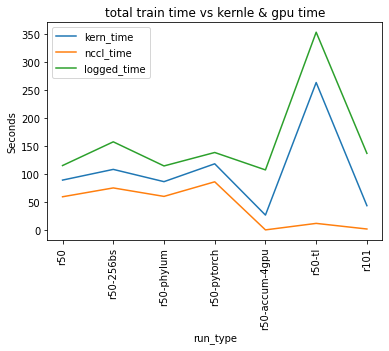

In [85]:
plt.title('total train time vs kernle & gpu time')
plt.xlabel('run_type')
plt.ylabel('Seconds')
plt.plot(df)
plt.legend(df.columns)
plt.xticks(rotation=90);

In [94]:
trial_desc = [
    'res50 + 512bs + species class + deep-taxon dataloader',
    'res50 + 256bs + species class + deep-taxon dataloader',
    'res50 + 512bs + phylum class + deep-taxon dataloader',
    'res50 + 512bs + species class + dt dl + pytorch training loop',
    'res50 + 512bs + 4epoch grad accum + species class + dt dl',
    'res50 + 512bs + species class + theoretical limit dataloader',
    'res101 + 512bs + species classification, deep-taxon dataloader'
]

In [96]:
df['description'] = trial_desc
df.to_csv('train_vs_gpu_time.csv', index=False)

In [97]:
df

,kern_time,nccl_time,logged_time,description
r50,89.534423,59.748935,115.527566,res50 + 512bs + species class + deep-taxon dat...
r50-256bs,108.656416,75.542611,157.893071,res50 + 256bs + species class + deep-taxon dat...
r50-phylum,86.737554,60.404087,114.824708,res50 + 512bs + phylum class + deep-taxon data...
r50-pytorch,118.635044,86.476833,138.846552,res50 + 512bs + species class + dt dl + pytorc...
r50-accum-4gpu,27.056760,0.589333,107.724616,res50 + 512bs + 4epoch grad accum + species cl...
r50-tl,263.834143,12.202738,353.708149,res50 + 512bs + species class + theoretical li...
r101,43.845701,2.164545,137.305719,"res101 + 512bs + species classification, deep-..."
